In [1]:
# copied from github repo Nagy_inversion_GUI/grav_bathyI_no_GUI_updated.ipynb on 16/05/2021
# use env: Nagy_GUI
import pandas as pd
import numpy as np
import pygmt
from gravbox import *
import xarray as xr
from tqdm import tqdm
from pyproj import Transformer

In [2]:
os.chdir('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion')
os.getcwd()

'C:\\Users\\matthewt\\Documents\\Python_Scripts\\RIS_gravity_inversion'

Import and grid gravity data

In [3]:
# forsberg compilation
# includes AngGG, DTU Space, PolarGap, OIB,a ROSETTA, GOCE
# FA is free-air anom at geioid, DG is disturbance (FA at ellipsoid), BA is bouguer anom (free air at sea) 
# antgg_update_tif = rioxarray.open_rasterio('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_fa.tif')
reg=[-1200000, 1000000, -2000000, 200000]

file ='gravity_data/ant4d_gravity.dat'
antgg_update = pd.read_csv(file, delim_whitespace=True, 
                           skiprows=3, names=['id', 'lat', 'lon', 'FA', 'Err', 'DG', 'BA'])

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
antgg_update['x'], antgg_update['y'] = transformer.transform(antgg_update.lat.tolist(), antgg_update.lon.tolist())

antgg_update = pygmt.blockmedian(antgg_update[["x", "y", "FA"]], 
                                         spacing="10000+e", 
                                         region=reg)

antgg_update_grid = 'gravity_data/ant4d_gravity.nc'
pygmt.surface(data=antgg_update[['x','y','FA']], 
                            spacing=20000, 
                            region=reg,
                            M='1c',
                            outgrid=antgg_update_grid
                            )

surface [WARNING]: 36518 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


In [4]:
inv_region="-1060000/900000/-1900000/60000"
!gmt grdsample -R{inv_region} -rg -I40e3  gravity_data/ant4d_gravity.nc -Ginversion_layers/gravity_inv.nc
!gmt grdsample -R{inv_region} -rg -I40e3  inversion_layers/bedmachine/BedMachine_surface_5k_filled.nc -Ginversion_layers/BedMachine_surface_filled_inv.nc
!gmt grdsample -R{inv_region} -rg -I40e3  inversion_layers/bedmachine/BedMachine_icebase_5k_filled.nc -Ginversion_layers/BedMachine_icebase_filled_inv.nc
!gmt grdsample -R{inv_region} -rg -I40e3  inversion_layers/bedmachine/BedMachine_bed_5k.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_region} -rg -I40e3  ../inversion_layers/RE_basement_BedMachinebed_filled.nc -G../inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 
!gmt grdsample -R{inv_region} -rg -I40e3  inversion_layers/ANTASed_mag_basement_filled.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


Import data and save properties as variables

In [5]:
layers_list =['gravity',
             'ice',
             'water',
             'layer1',
            #  'layer2',
             ]
spacing_list = [40e3,
                40e3,
                40e3,
                40e3,
                # 40e3,
                ]
rho_list = ['NaN',
            0.92,
            1.03,
            2.6,
            # 2.8,
            ]

fname_list=[
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/gravity_inv.nc',
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_surface_filled_inv.nc',
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_icebase_filled_inv.nc',
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_bed_inv.nc',
            # 'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc',
            ]

layers = {j:{'spacing':spacing_list[i], 'fname':fname_list[i], 'rho':rho_list[i]} for i, j in enumerate(layers_list)}

for k, v in layers.items():
    if k == 'gravity':
        if v['fname'][-3:]=='.nc':
            v['grid']=xr.open_dataarray(v['fname'])
            v['df']=xr.open_dataarray(v['fname']).to_dataframe().reset_index()
            v['df'].rename(columns={'z':'Gobs'}, inplace=True)
        else:       
            v['df']=pd.read_csv(v['fname'], sep='\t', header=None, names=['x', 'y', 'Gobs'])
        # v['df']['z']=750
        v['df'].dropna(how='any', inplace=True)
    else:
        v['grid']=pygmt.load_dataarray(v['fname'])
        v['df']=pygmt.grd2xyz(v['grid'])
        # v['grid']=xr.open_dataarray(v['fname'])
        # v['df']=xr.open_dataarray(v['fname']).to_dataframe().reset_index()
        v['df']['rho']=v['rho']
    v['len']=len(v['df'].x)

layers['gravity']['df']['z']=layers['ice']['grid'].to_dataframe().reset_index().z+750

for k, v in layers.items():
    print(f"points in {k} file: {v['len']}")   

points in gravity file: 2500
points in ice file: 2500
points in water file: 2500
points in layer1 file: 2500


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


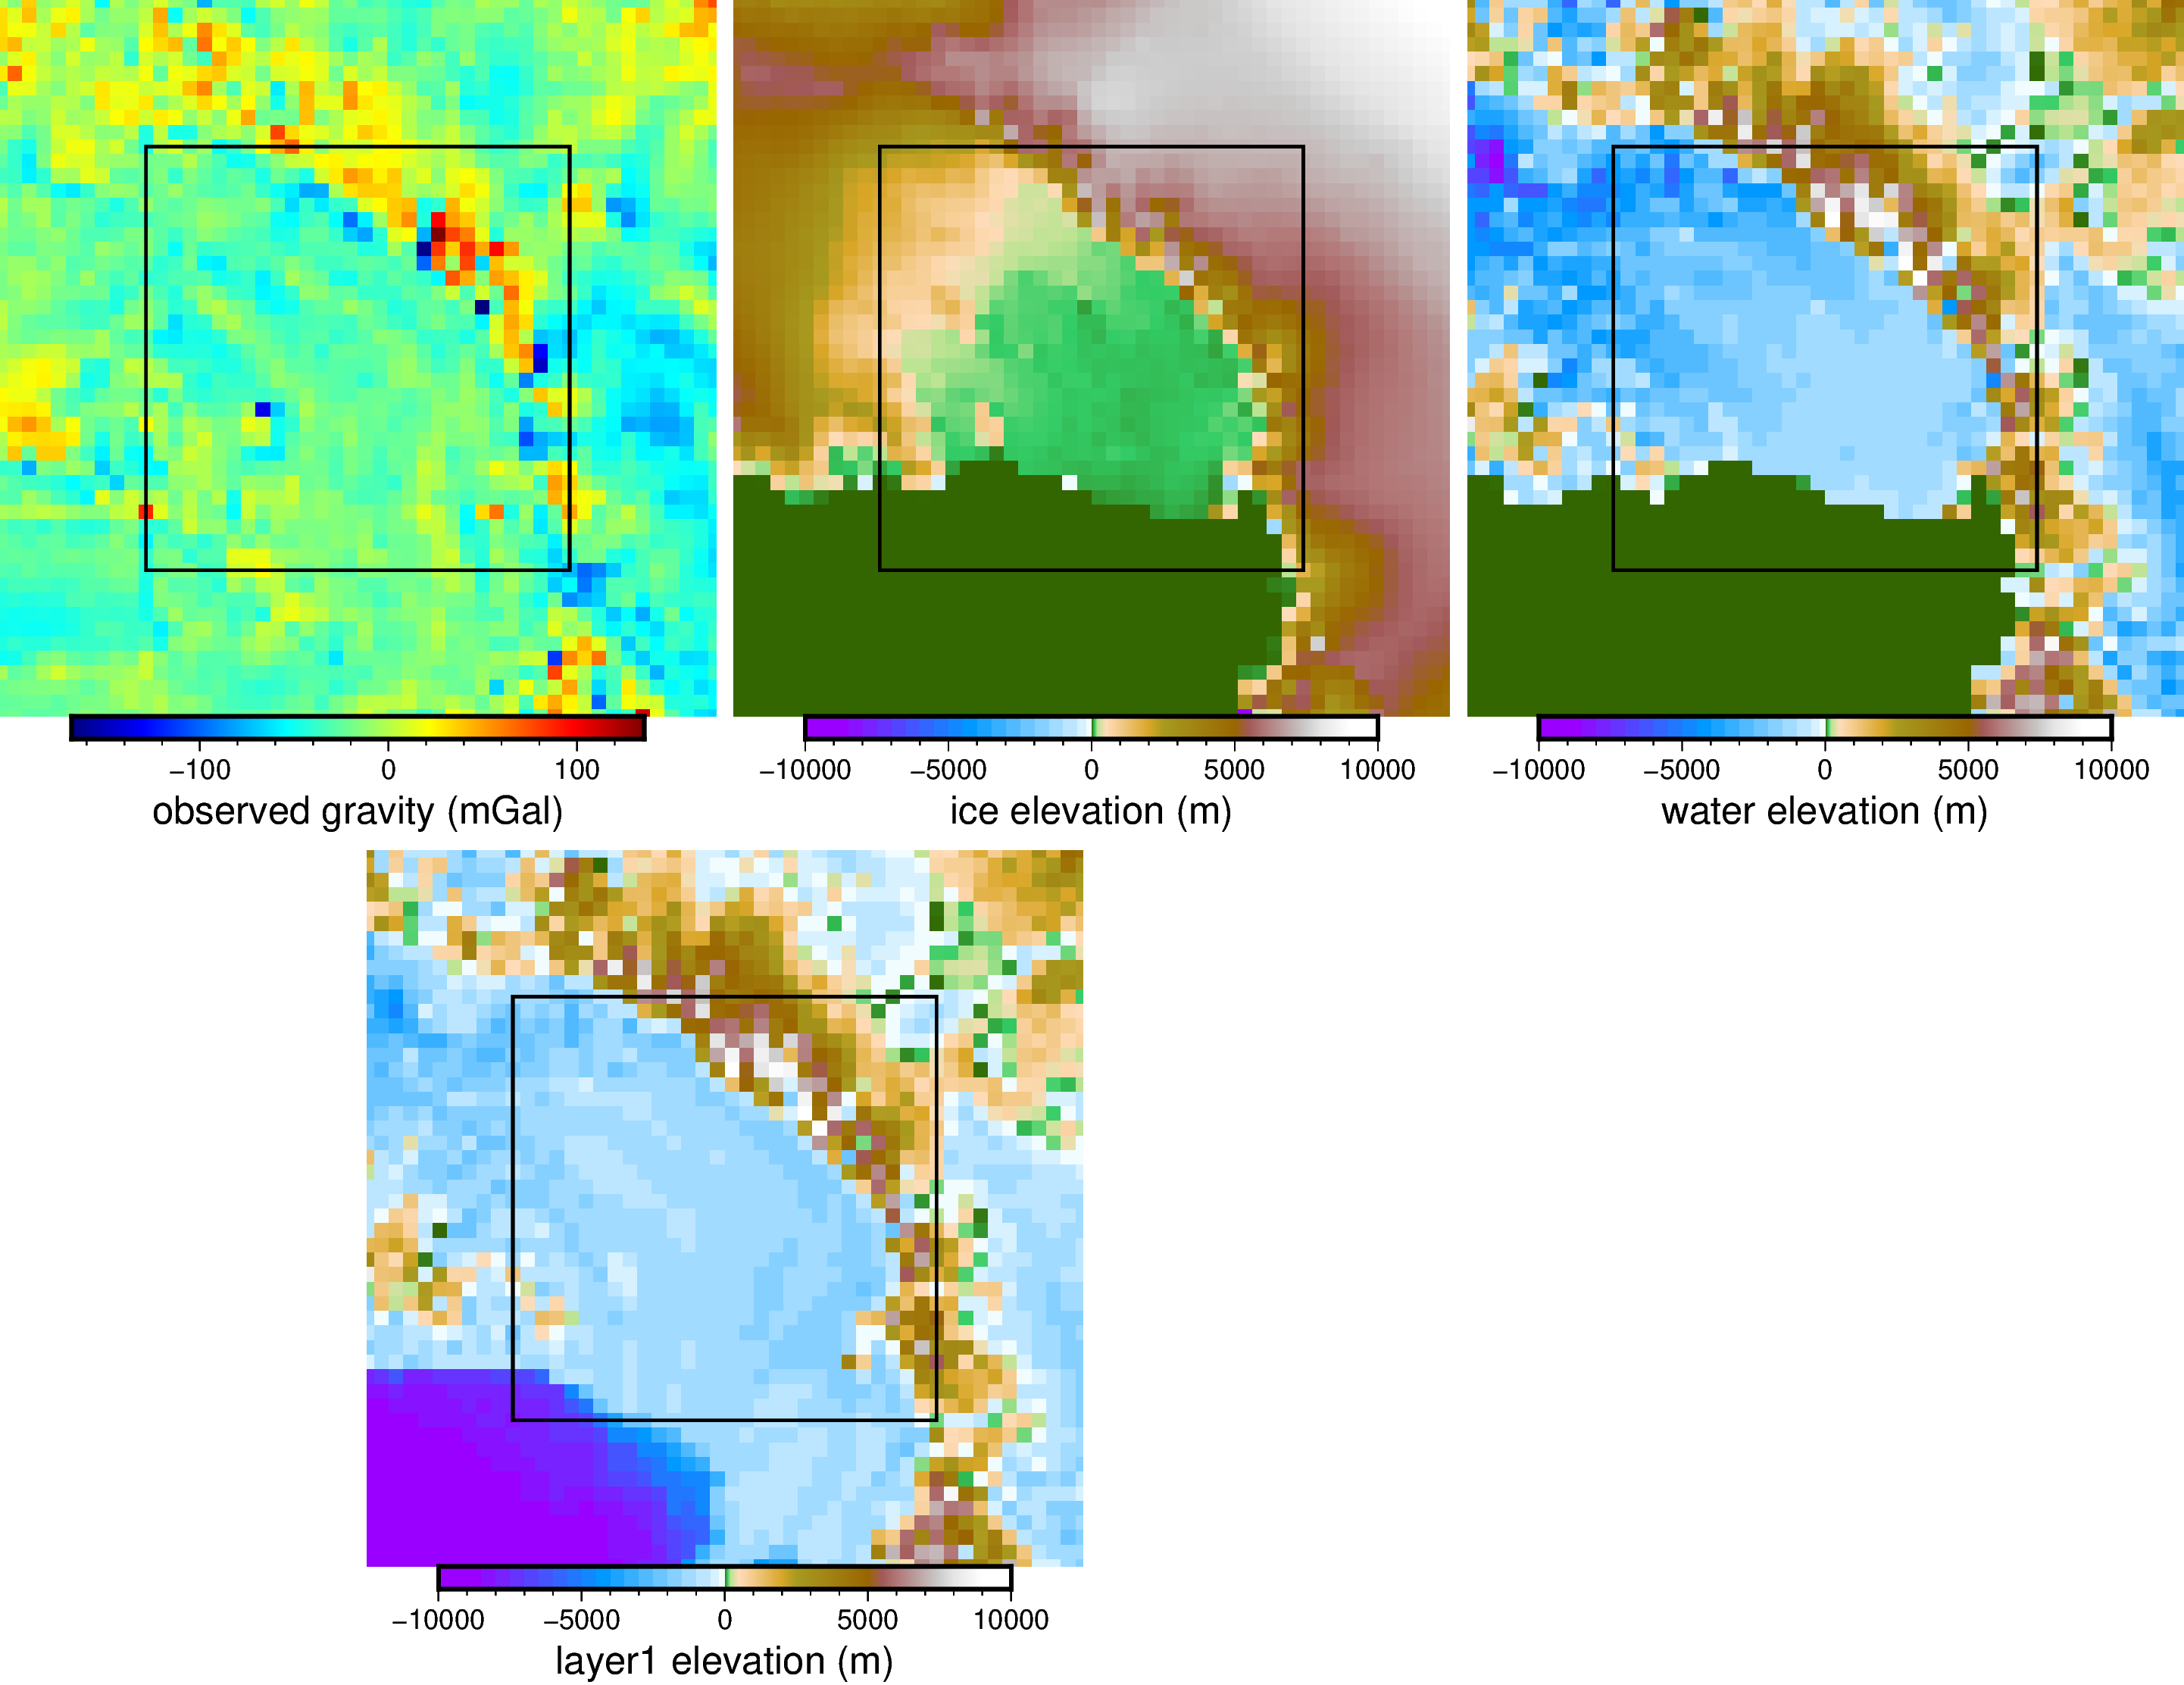

In [6]:
e_inv = np.array(layers['ice']['grid'].x).min()
w_inv = np.array(layers['ice']['grid'].x).max()
n_inv = np.array(layers['ice']['grid'].y).min()
s_inv = np.array(layers['ice']['grid'].y).max()
inv_reg = [e_inv, w_inv, n_inv, s_inv]

inv_height = 80
inv_width = inv_height*(w_inv-e_inv)/(s_inv-n_inv)
inv_ratio = (s_inv-n_inv)/(inv_height/1000)
inv_proj = f"x1:{inv_ratio}"

buffer = 400e3
e_fig = e_inv+buffer
w_fig = w_inv-buffer
n_fig = n_inv+buffer
s_fig = s_inv-buffer
fig_reg = [e_fig, w_fig, n_fig, s_fig]

fig_height = 80
fig_width = fig_height*(w_fig-e_fig)/(s_fig-n_fig)
fig_ratio = (s_fig-n_fig)/(fig_height/1000)
fig_proj = f"x1:{fig_ratio}"

layers['gravity']['grid']=pygmt.surface(data=layers['gravity']['df'][['x','y','Gobs']], 
                                        spacing=layers['gravity']['spacing'], region=inv_reg, M='1c')

spacing=layers['ice']['spacing']

# grid the data with pygmt.surface()
# for k, v in layers.items():
#     spacing=layers[k]['spacing']
#     data=layers[k]['df']
#     fig_height = 80
    # e, w = data.x.min(), data.x.max()
    # n, s = data.y.min(), data.y.max()
    # e, w = data.x.min()//spacing*spacing, data.x.max()//spacing*spacing
    # n, s = data.y.min()//spacing*spacing, data.y.max()//spacing*spacing
    # fig_width = fig_height*(w-e)/(s-n)
    # fig_ratio = (s-n)/(fig_height/1000)
    # fig_reg = f'{e}/{w}/{n}/{s}'
    # fig_proj = f"x1:{fig_ratio}"

    # if k == 'gravity':
    #     layers[k]['grid']=pygmt.surface(data=data[['x','y','Gobs']], 
    #     region=fig_reg, spacing=spacing, M='1c', registration='g')
    # else:
    #     layers[k]['grid']=pygmt.surface(data=data[['x','y','z']],
    #     region=fig_reg, spacing=spacing, M='1c', registration='g')
        
# plot the grids
fig = pygmt.Figure()

for i, (k, v) in enumerate(layers.items()):
    data=layers[k]['grid']
    if k == 'gravity':
        pygmt.makecpt(cmap="jet", series=[data.min().item(), data.max().item()], background=True)
        fig.grdimage(
            data,
            cmap=True,
            projection=inv_proj, 
            region=inv_reg,
            nan_transparent=True,
            frame=['+gwhite'])
        fig.colorbar(cmap=True, position='jBC+jTC+h', frame='x+l"observed gravity (mGal)"')
    else:
        fig.grdimage(
            data,
            cmap='globe',
            projection=inv_proj, 
            region=inv_reg,
            nan_transparent=True,
            frame=['+gwhite'])
        fig.colorbar(cmap='globe', position='jBC+jTC+h', frame=f'x+l"{k} elevation (m)"')

    # plot later figure extents (without inv buffer)
    fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
             y = [n_fig, s_fig, s_fig, n_fig, n_fig], 
             pen = '1p,black')
    
    if i == len(layers)//2:
        fig.shift_origin(yshift=(-inv_height-15)/10, xshift=((-inv_width-2)*1.5)/10)
    else:
        fig.shift_origin(xshift=(inv_width+2)/10)
fig.show()

In [7]:
# set z_lower to be equal to lower layers 
# if layer resolutions are different, need to

# list of layers, bottom up, without gravity layer
reversed_layers_list = np.flip(layers_list[1:])
for i, j in enumerate(reversed_layers_list):
    if i == 0:
        layers[j]['df']['z_low'] = -50e3
        print(f'mean elevation of {j} top: {layers[j]["df"].z.mean()} and bottom: {layers[j]["df"].z_low.mean()}')
    else:
        if layers[j]['spacing'] != layers[reversed_layers_list[i-1]]['spacing']:
            print(f"resolutions don't match for {j} ({layers[j]['spacing']}m) and {reversed_layers_list[i-1]} ({layers[reversed_layers_list[i-1]]['spacing']}m)")
            print(f"resampling {reversed_layers_list[i-1]} to match {j}")
            
            # attempt with grdsample: gave extreme low/high values
            # tmp=pygmt.grdsample(grid=layers[reversed_layers_list[i-1]]['grid'], spacing=layers[j]['spacing'], region=fig_reg)
            # df_regrid=tmp.to_dataframe().reset_index().rename(columns={'z':'z_regrid'})
            # layers[j]['df']['z_low']=layers[j]['df'].merge(df_regrid, how='left', on=['x','y']).z_regrid

            df_regrid=pygmt.grdtrack(points=layers[j]['df'][['x','y']], grid=layers[reversed_layers_list[i-1]]['grid'], newcolname='z_regrid')
            layers[j]['df']['z_low']=layers[j]['df'].merge(df_regrid, how='left', on=['x','y']).z_regrid
            # layers[j]['df']['z_low'].mean()

            print(f'mean elevation of {j} top: {layers[j]["df"].z.mean()} and bottom: {layers[j]["df"].z_low.mean()}')
        else:
            layers[j]['df']['z_low'] = layers[reversed_layers_list[i-1]]['df'].z
            print(f'mean elevation of {j} top: {layers[j]["df"].z.mean()} and bottom: {layers[j]["df"].z_low.mean()}')

mean elevation of layer1 top: -533.0086958823993 and bottom: -50000.0
mean elevation of water top: 6.555523806950217 and bottom: -533.0086958823993
mean elevation of ice top: 1266.3220346125133 and bottom: 6.555523806950217


In [8]:
# Calculate inital forward gravity model of input layers

df_grav = layers['gravity']['df']
# z_bot = 0 # for equivalent densities

# add column of density corrections values, initially set to 0
for k, v in layers.items():
    if k == 'gravity':
        pass
    else:
        v['df']['density_corr']=0
        
# set z_lower to be equal to lower layers 
# if layer resolutions are different, need to resample
# reversed_layers_list = np.flip(layers_list[1:])
# for i, j in enumerate(reversed_layers_list):
#     if i == 0:
#         layers[j]['df']['z_low'] = -50e3
#         print(f'mean elevation of {j} top: {layers[j]["df"].z.mean()} and bottom: {layers[j]["df"].z_low.mean()}')
#     else:
#         layers[j]['df']['z_low'] = layers[reversed_layers_list[i-1]]['df'].z
#         print(f'mean elevation of {j} top: {layers[j]["df"].z.mean()} and bottom: {layers[j]["df"].z_low.mean()}')

# calculate forward gravity
for k, v in layers.items():
    if k == 'gravity':
        pass
    else:
        df = layers[k]['df']
        spacing = (layers[k]['spacing'])/2
        forward_grav=[]
        print(f'calculated forward gravity of layer:{k}')
        for i,j in enumerate(tqdm(layers['gravity']['df'].Gobs)):
            # check if append here is the fastest option! Currently much slower than Harmonica's forward grav calculations
            forward_grav.append(sum(gravbox(
                                df_grav.y.iloc[i], # coords of gravity observation points
                                df_grav.x.iloc[i],
                                df_grav.z.iloc[i],
                                (df.y-spacing).to_numpy(), # prisms' edge coordinates
                                (df.y+spacing).to_numpy(),
                                (df.x-spacing).to_numpy(),
                                (df.x+spacing).to_numpy(),
                                (df.z).to_numpy(),      # prisms' top
                                (df.z_low).to_numpy(),  # prism's bottom
                                (df.rho).to_numpy())))  # prisms' density 
        df_grav[f'{k}_forward_grav'] = forward_grav # add forward gravity of each layer, at gravity observation points, as new column in gravity dataframe

# add gravity effects of all input layers
for i, j in enumerate(layers_list):
    if j == 'gravity':
        pass
    elif i == 1:
        df_grav['forward_grav_total'] = df_grav[f'{j}_forward_grav']
    else:
        df_grav['forward_grav_total'] += df_grav[f'{j}_forward_grav']

df_grav

calculated forward gravity of layer:ice


100%|██████████| 2500/2500 [00:05<00:00, 469.52it/s]


calculated forward gravity of layer:water


100%|██████████| 2500/2500 [00:03<00:00, 733.41it/s]


calculated forward gravity of layer:layer1


100%|██████████| 2500/2500 [00:03<00:00, 704.23it/s]


,y,x,Gobs,z,ice_forward_grav,water_forward_grav,layer1_forward_grav,forward_grav_total
0,-1900000.0,-1060000.0,-23.000000,750.000000,0.000809,184.314017,2658.157165,2842.471991
1,-1900000.0,-1020000.0,-21.049999,750.000000,0.000842,177.874183,3189.214206,3367.089230
2,-1900000.0,-980000.0,-26.799999,750.000000,0.000871,178.513962,3338.426691,3516.941523
3,-1900000.0,-940000.0,-26.600000,750.000000,0.000894,180.065954,3402.046978,3582.113826
4,-1900000.0,-900000.0,-24.969999,750.000000,0.000912,178.629057,3443.218694,3621.848663
...,...,...,...,...,...,...,...,...
2495,60000.0,740000.0,-2.110000,4325.967773,111.454763,0.010270,3797.786442,3909.251475
2496,60000.0,780000.0,12.319999,4362.918945,99.018946,0.009967,3792.430199,3891.459113
2497,60000.0,820000.0,1.270000,4421.884766,113.030039,0.009707,3679.627117,3792.666863
2498,60000.0,860000.0,56.729992,4474.460938,85.409528,0.009439,3591.544373,3676.963341


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


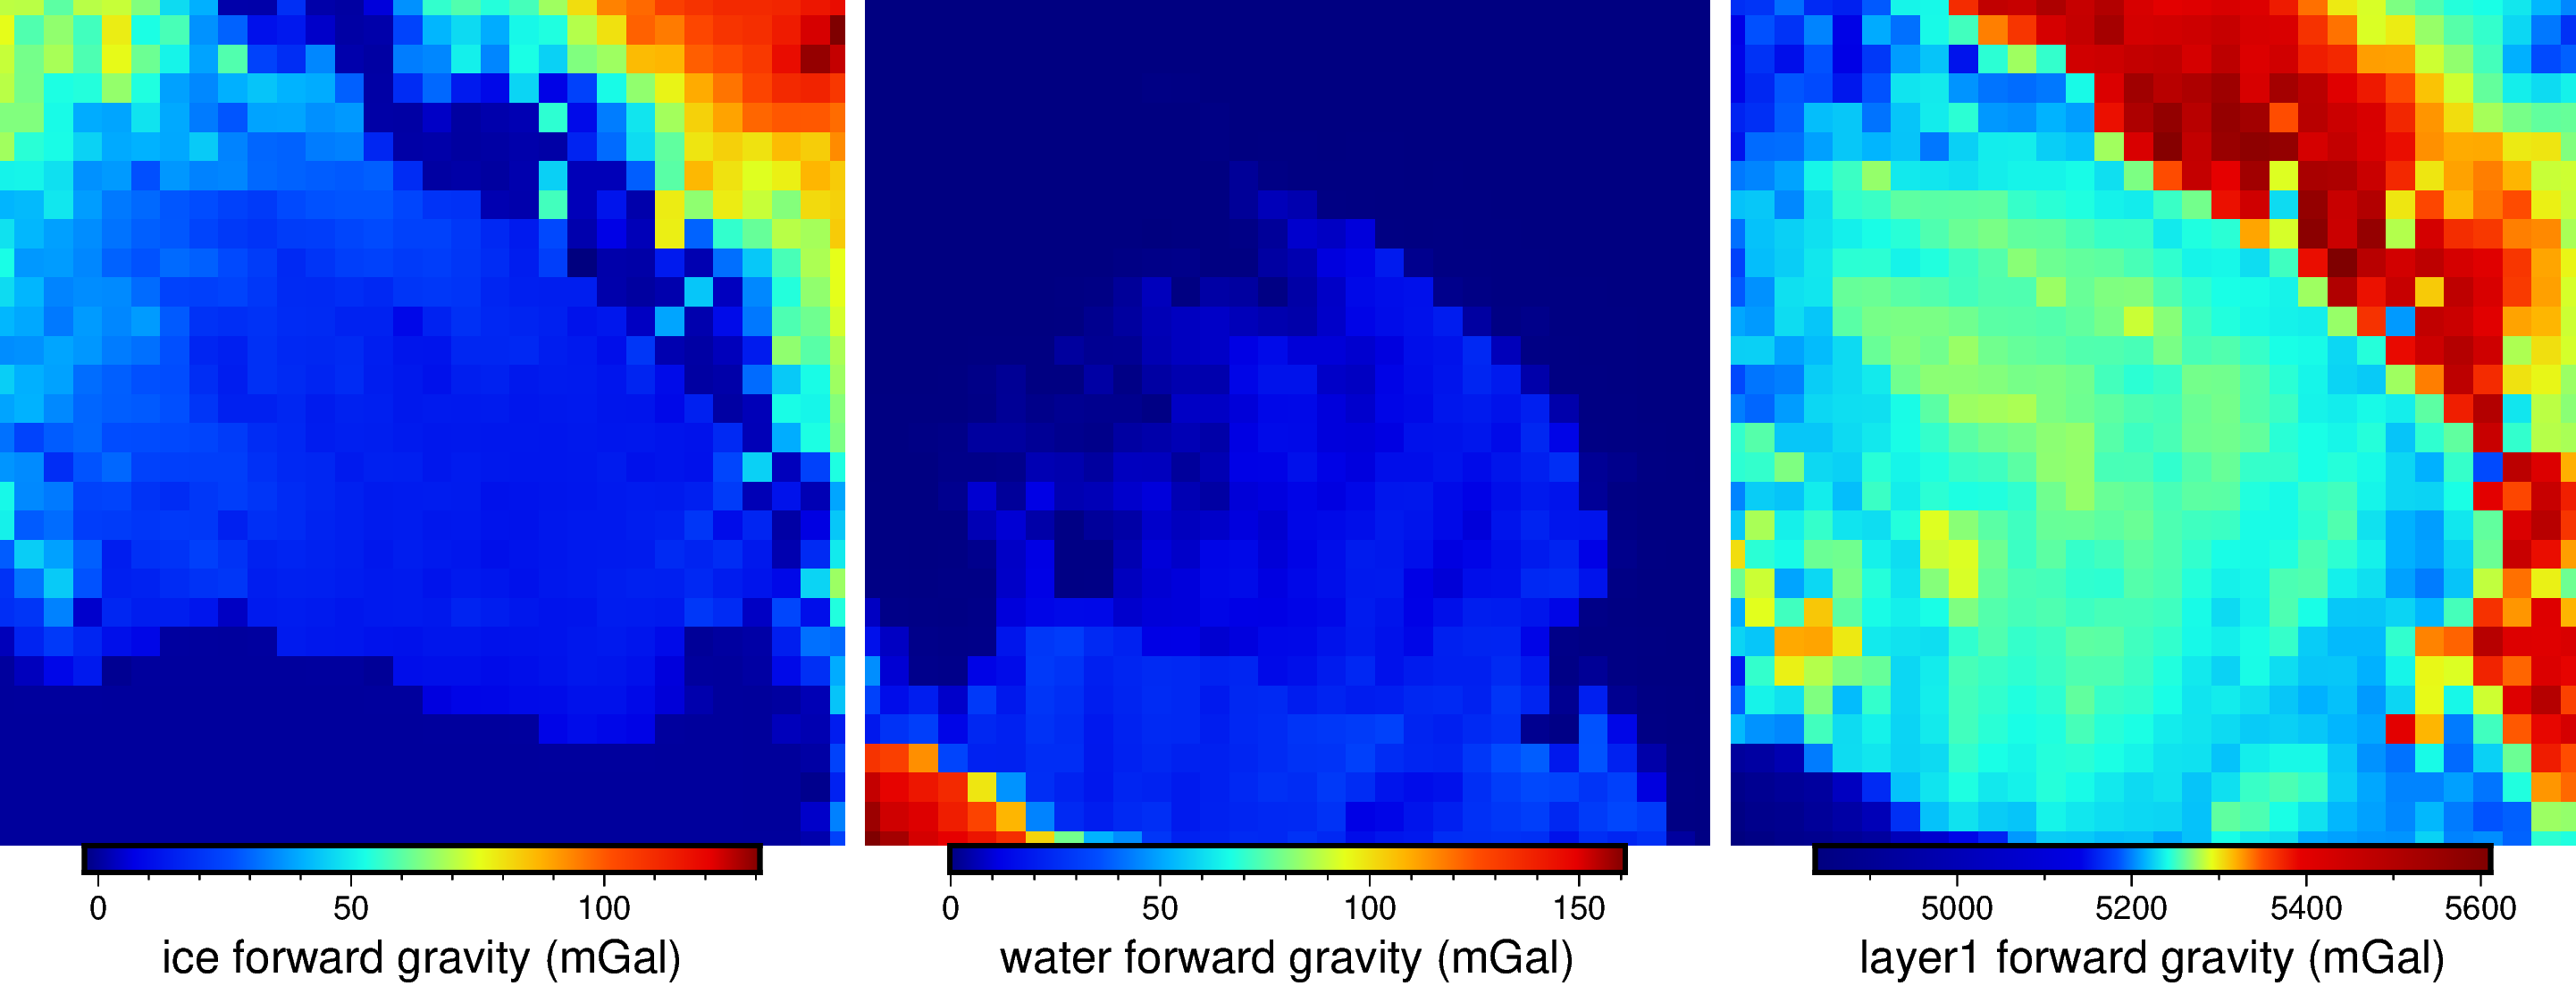

In [9]:
# plot forward grav results of each layer
fig = pygmt.Figure()

for k, v in layers.items():
    if k == 'gravity':
        pass
    else:
        layers[k]['forward_grav_grid'] = pygmt.xyz2grd(data = df_grav[['x','y',f"{k}_forward_grav"]],
                                 region=inv_reg, 
                                 spacing=layers['gravity']['spacing'], 
                                 projection=inv_proj)

for i, (k, v) in enumerate(layers.items()):
    if k == 'gravity':
        pass
    else:
        data=layers[k]['forward_grav_grid']
        # for comparing with fatiando forward gravity
        # if k == 'layer1':
        #     pygmt.makecpt(cmap="jet", series=[-200, 800], background=True, continuous=True)
        # elif k == 'layer2':
        #     pygmt.makecpt(cmap="jet", series=[4800, 6000], background=True, continuous=True)
        # else:
        #     pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True, continuous=True)
        pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True, continuous=True)
        fig.grdimage(
            data,
            cmap=True,
            projection=fig_proj, 
            region=fig_reg,
            frame=['+gwhite'])
        fig.colorbar(cmap=True, position='jBC+jTC+h', frame=f'x+l"{k} forward gravity (mGal)"')
    fig.shift_origin(xshift=(fig_width+2)/10)
fig.show()

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


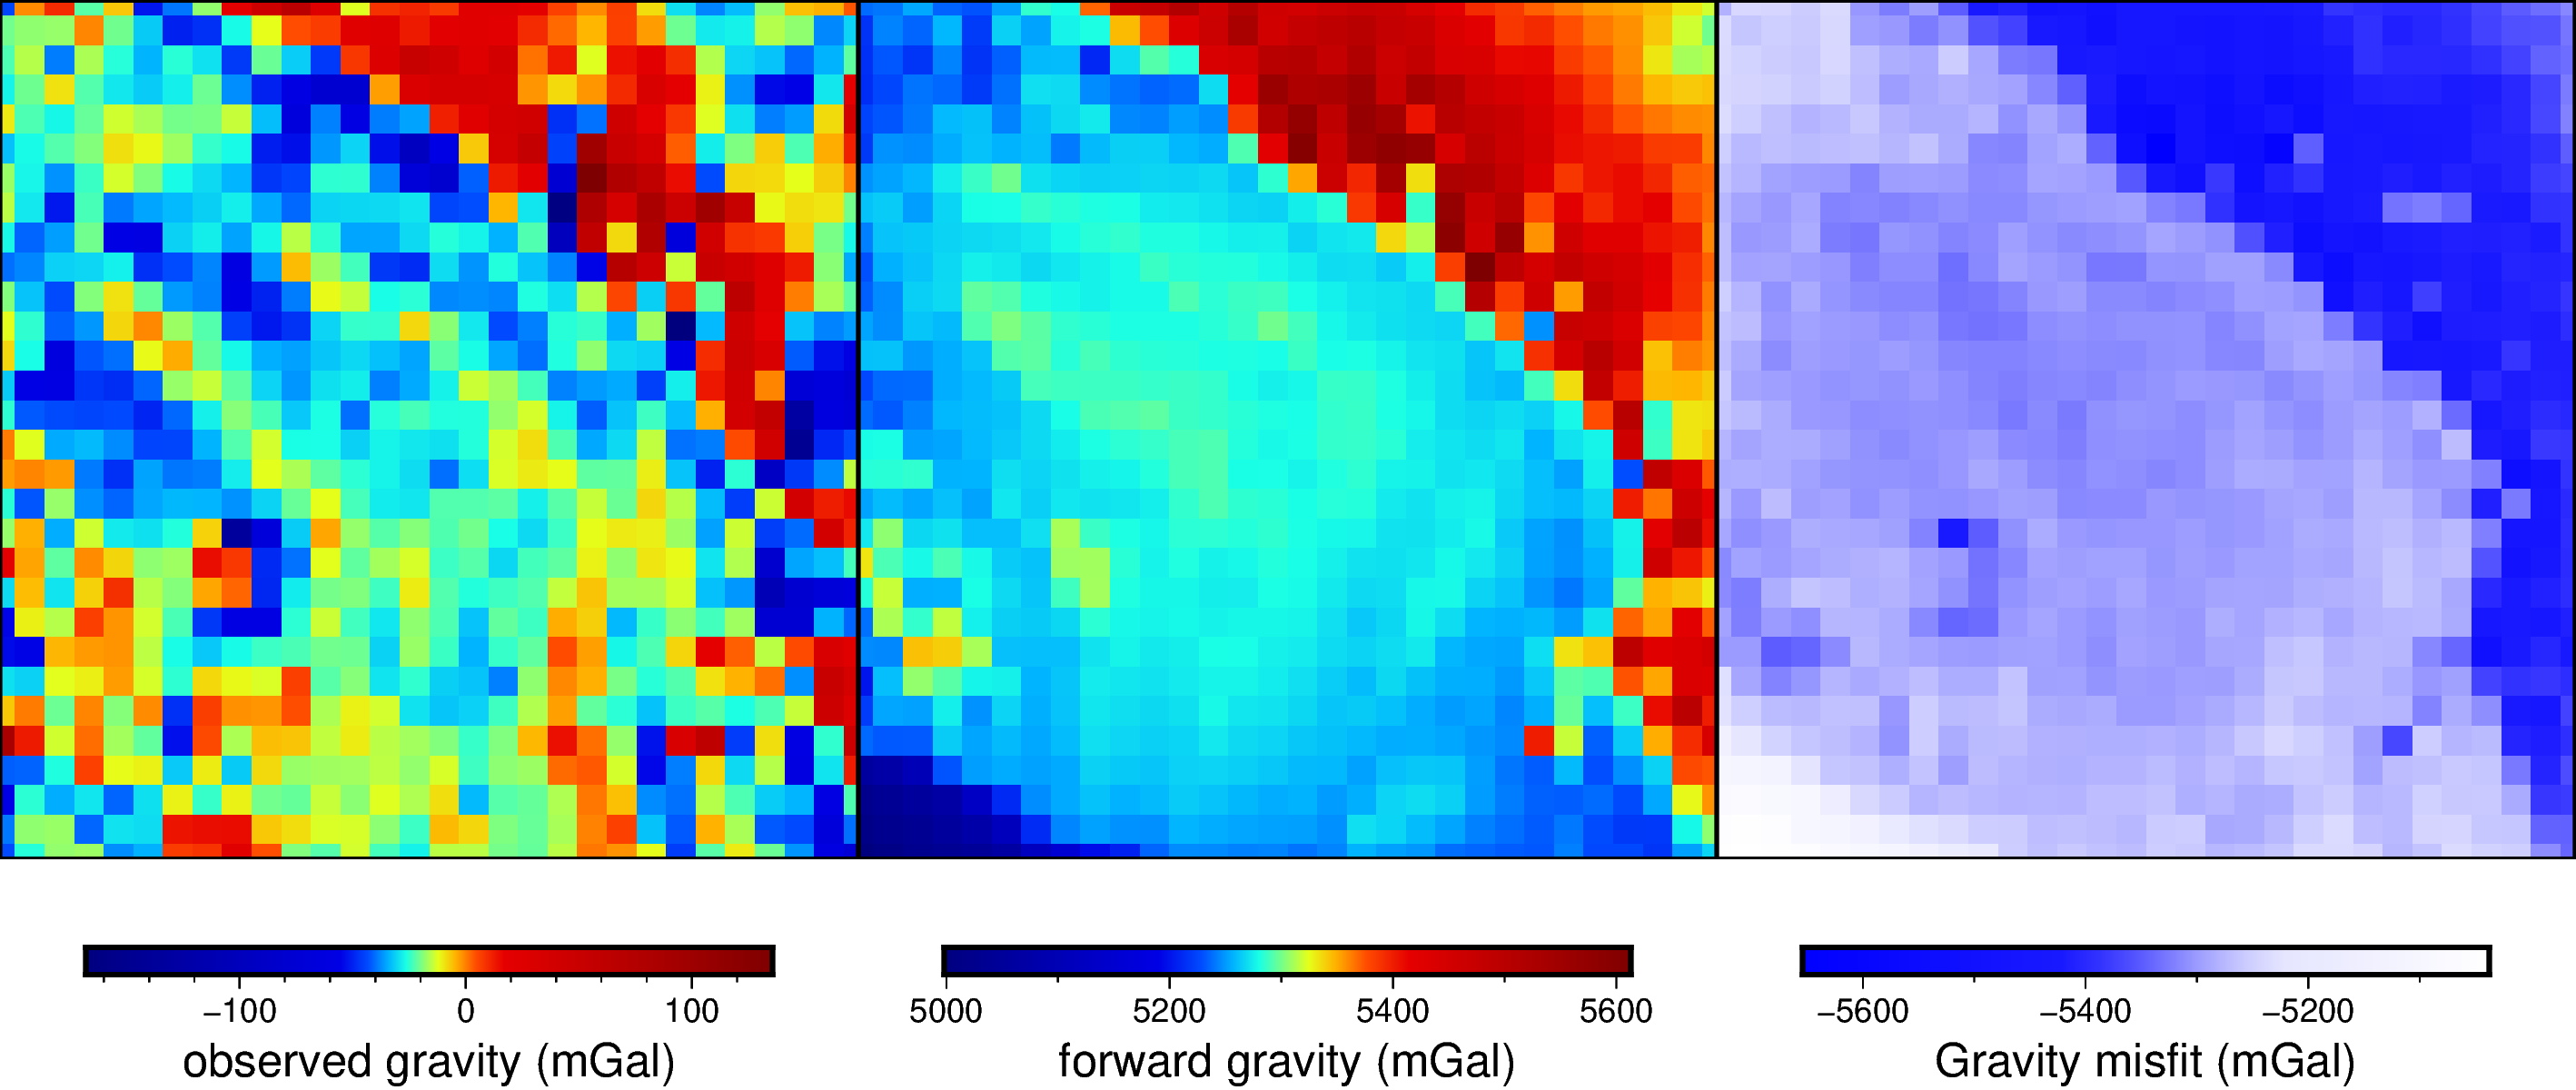

In [10]:
# plot observed, forward, and misfit gravity grids

# subtract forward grav from observed gravity 
# THIS IS DIFFERENT TO FABIO'S, HE SUBTRACTS FACP
df_grav['forward_grav_misfit'] = df_grav.Gobs - df_grav.forward_grav_total


forward_grav_grid=pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_total']],
                                 region=inv_reg, 
                                 spacing=layers['gravity']['spacing'],
                                 projection=inv_proj)

misfit_grav_grid=pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_misfit']],
                                 region=inv_reg, 
                                 spacing=layers['gravity']['spacing'],
                                 projection=inv_proj)

fig = pygmt.Figure()

# plot observed gravity
data=layers['gravity']['grid']
pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True, continuous=True)
fig.grdimage(
        data,
        cmap=True,
        projection=fig_proj, 
        region=fig_reg,
        nan_transparent=True,
        frame=['+gwhite'])

fig.colorbar(cmap=True, frame='af+l"observed gravity (mGal)"')

# plot later figure extents (without inv buffer)
fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
            y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
            pen = '1p,black')

# plot forward gravity
fig.shift_origin(xshift=(fig_width)/10)
data=forward_grav_grid
pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True, continuous=True)
fig.grdimage(
        data,
        cmap=True,
        projection=fig_proj, 
        region=fig_reg,
        nan_transparent=True,
        frame=['+gwhite'])

fig.colorbar(cmap=True, frame='af+l"forward gravity (mGal)"')

# plot later figure extents (without inv buffer)
fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
            y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
            pen = '1p,black')

# plot misfit gravity
fig.shift_origin(xshift=(fig_width)/10)
data=misfit_grav_grid
pygmt.grd2cpt(cmap="polar+h0", grid=data, region=fig_reg, background=True, continuous=True)
fig.grdimage(
        data,
        cmap=True,
        projection=fig_proj, 
        region=fig_reg,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, frame='af+l"Gravity misfit (mGal)"')
# plot later figure extents (without inv buffer)
fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
            y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
            pen = '1p,black')

fig.show()

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


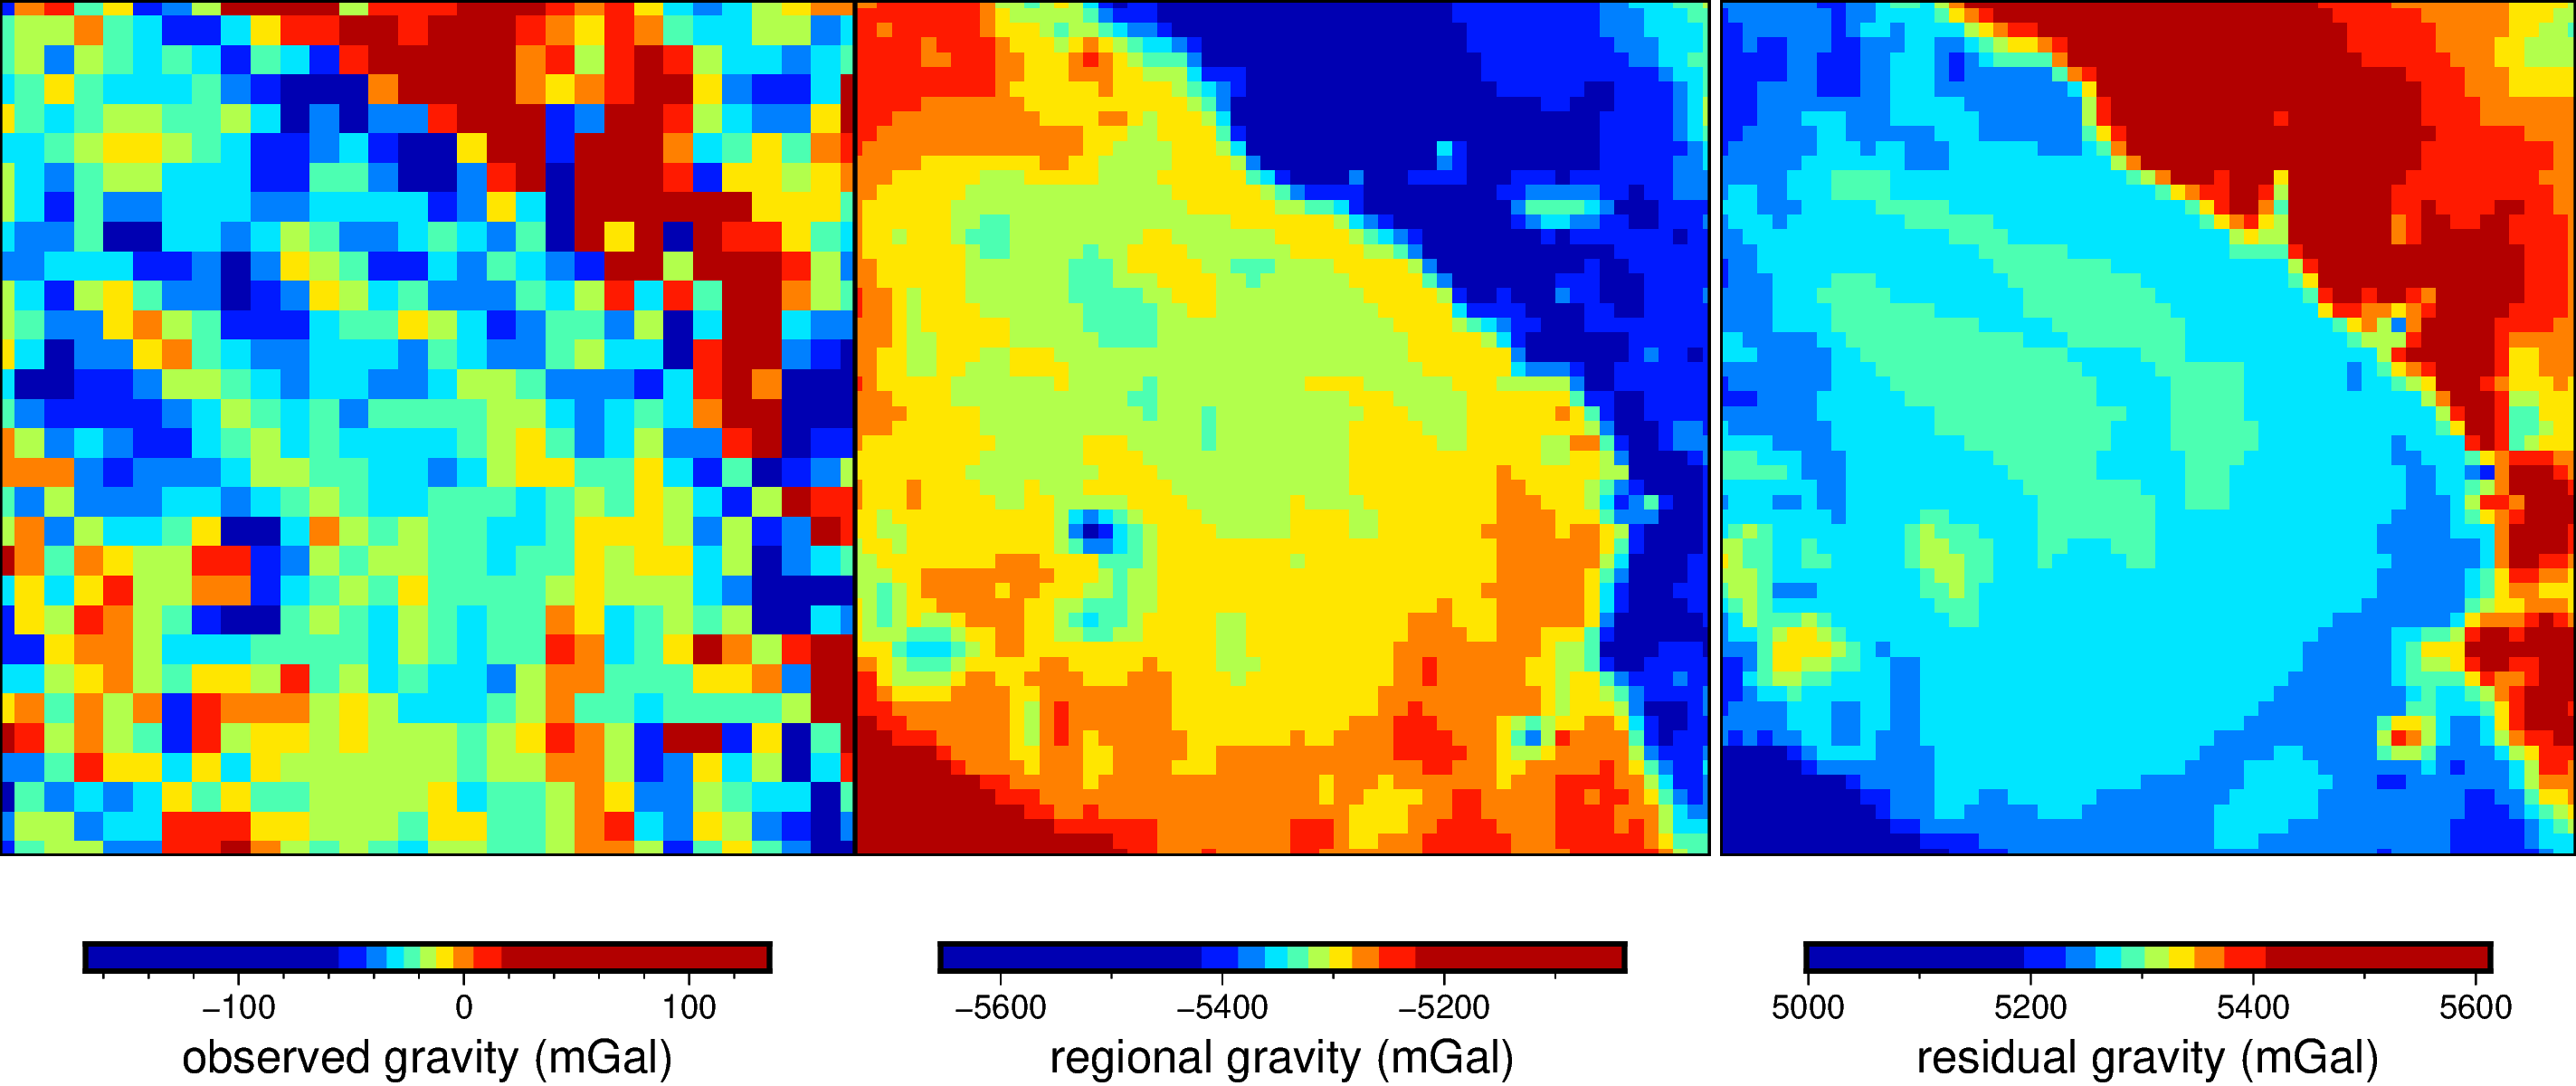

In [11]:
# TREND_TYPE = 'Constant value'
# TREND_TYPE = 'Linear'
TREND_TYPE = 'Full regional correction'

# set type of regional correction
if TREND_TYPE == "Constant value":
    df_grav['regional_grav'] = df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean()
    # df_grav['regional_grav'] = df_grav.forward_grav_misfit.mean()
    print(df_grav['regional_grav'].mean())

elif TREND_TYPE == 'Linear':
    # ATEMP=np.column_stack((np.ones(len(df_grav.Gobs[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])), 
    #                         df_grav.x[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))], 
    #                         df_grav.y[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))]))
    # C,RESID,RANK,SIGMA=np.linalg.lstsq(ATEMP,df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])
    # df_grav['regional_grav'] = C[0]*np.ones(len(df_grav.Gobs[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])) + C[1]*df_grav.y[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))] + C[2]*df_grav.x[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))]
    ATEMP=np.column_stack((np.ones(len(df_grav.Gobs)), 
                            df_grav.x, 
                            df_grav.y))
    C,RESID,RANK,SIGMA=np.linalg.lstsq(ATEMP,df_grav.forward_grav_misfit)
    df_grav['regional_grav'] = C[0]*np.ones(len(df_grav.Gobs)) + C[1]*df_grav.y + C[2]*df_grav.x
    # print(C[0])
    
elif TREND_TYPE == 'Full regional correction':
     df_grav['regional_grav'] = df_grav.forward_grav_misfit

# calculate residual gravity to be inverted
df_grav['residual_grav'] = df_grav.Gobs - df_grav.regional_grav 

residual_grav_grid=pygmt.surface(data = df_grav[['x','y','residual_grav']],
                                 region=inv_reg, 
                                 spacing=spacing, 
                                 M='1c', 
                                 registration='g')

regional_grav_grid=pygmt.surface(data = df_grav[['x','y','regional_grav']],
                                 region=inv_reg, 
                                 spacing=spacing, 
                                 M='1c', 
                                 registration='g')

# plot the grids
fig = pygmt.Figure()

# plot observed gravity
data=layers['gravity']['grid']
pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
fig.grdimage(
        data,
        cmap=True,
        projection=fig_proj, 
        region=fig_reg,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, frame='af+l"observed gravity (mGal)"')
# plot later figure extents (without inv buffer)
fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
            y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
            pen = '1p,black')

# plot regional gravity
fig.shift_origin(xshift=(fig_width)/10)
data=regional_grav_grid
try:
    pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
    # pygmt.makecpt(cmap="jet", series=[data.min().item(), data.max().item()], background=True)
except:
    pass
fig.grdimage(
    data,
    cmap=True,
    projection=fig_proj, 
    region=fig_reg,
    nan_transparent=True,
    frame=['+gwhite'])
fig.colorbar(cmap=True, frame='af+l"regional gravity (mGal)"')
# plot later figure extents (without inv buffer)
fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
            y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
            pen = '1p,black')

# plot residual gravity
fig.shift_origin(xshift=(fig_width+1)/10)
data=residual_grav_grid
pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
fig.grdimage(
    data,
    cmap=True,
    projection=fig_proj, 
    region=fig_reg,
    nan_transparent=True,
    frame=['+gwhite'])
fig.colorbar(cmap=True, frame='af+l"residual gravity (mGal)"')
# plot later figure extents (without inv buffer)
fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
            y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
            pen = '1p,black')

fig.show()

In [12]:
df_grav['initial_misfit'] = df_grav.Gobs - df_grav.forward_grav_total
shift = df_grav.initial_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean() 
print(f'average misfit between Gobs and forward gravity within figure region is {int(shift)} mGal')

df_grav['Gobs_shift'] = df_grav.Gobs - shift
print(f'average Gobs_shifted: {int(df_grav.Gobs_shift[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean())} mGal')
print(f'average forward gravity total: {int(df_grav.forward_grav_total[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean())} mGal')

df_grav['forward_grav_misfit'] = df_grav.Gobs_shift - df_grav.forward_grav_total

average misfit between Gobs and forward gravity within figure region is -5321 mGal
average Gobs_shifted: 5302 mGal
average forward gravity total: 5302 mGal


In [14]:
from grav_column_der import grav_column_der
from scipy.sparse.linalg import lsqr

df = layers['layer1']['df']
df['z_updated']=df.z
# df_grav['grav_inversion']=df_grav.residual_grav - df_grav.forward_grav_total

df_grav['grav_inversion']=df_grav.forward_grav_misfit

Tolerance_Least_Square_total=0.01
Tolerance_Least_Squares_iter=0.05
Max_Iterations=4
Tolerance_Bathymetry=20000 

MATDATPAR = (np.zeros([len(df_grav.Gobs),len(df)])) # array with NG number of rows and NBath+NBase+NM number of columns
MAT_DENS = (np.zeros([len(df_grav.Gobs),len(df)]))
    
misfit_sq_update=np.Inf  # positive infinity
DCHISQ=np.Inf  # positibe infinity

ITER=0
while DCHISQ > 1+Tolerance_Least_Squares_iter: # while DCHISQ is greater than 1 + least squares tolerance (0.02)
    ITER=ITER+1 
    print(f"iteration {ITER}") 
    spacing = layers['layer1']['spacing']
    forward_grav=[]   
    for i,j in enumerate(tqdm(layers['gravity']['df'].Gobs)):
        # Calculation of forward gravity for the geometries of the layer at each iteration, using Nagy's equation (gravbox)
        forward_grav.append(sum(gravbox(df_grav.y.iloc[i], # coords of gravity observation points
                                df_grav.x.iloc[i],
                                df_grav.z.iloc[i],
                                (df.y-spacing/2).to_numpy(), # prisms' edge coordinates
                                (df.y+spacing/2).to_numpy(),
                                (df.x-spacing/2).to_numpy(),
                                (df.x+spacing/2).to_numpy(),
                                (df.z_updated).to_numpy(),      # prisms' top
                                (df.z_low).to_numpy(),  # prism's bottom
                                (df.rho).to_numpy())))  # prisms' density 
        # Calculation of the Jacobian matrix using the annular cylinder approximation (grav_column_der)
        #MATDATPAR is matrix array with NG number of rows and NBath+NBase+NM number of columns
        # uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
        #SURFACE ELEVATION
        MATDATPAR[i,0:len(df)]=grav_column_der(df_grav.y.iloc[i], # coords of gravity observation points
                                               df_grav.x.iloc[i],
                                               df_grav.z.iloc[i],  
                                               df.y, df.x,     
                                               df.z_updated, df.z_low,     
                                               spacing,     
                                               df.rho)  # MATDATPAR[i,0:NBath] is i'th row and columns 0 to NBath

    # add forward gravity, at gravity observation points, as new column in gravity dataframe
    df_grav[f'forward_grav_{ITER}'] = forward_grav 
    
    # Calculation of gravity misfit DF, i.e., the difference between calculated and observed gravity
    df_grav[f'inv_misfit_{ITER}']=df_grav.grav_inversion-df_grav[f'forward_grav_{ITER}']

    # gives the amount that each column's Z1 needs to change by to have the smallest misfit
    Surface_correction=lsqr(MATDATPAR,df_grav[f'inv_misfit_{ITER}'],show=False)[0] # finds the least-squares solution to MATDATPAR and Grav_Misfit, assigns the first value to Surface_correction

    # if necesarry correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Surface_correction
    for i in range(0,len(df)):
        if Surface_correction[i] > Tolerance_Bathymetry:
            Surface_correction[i]=Tolerance_Bathymetry
        elif Surface_correction[i] < -Tolerance_Bathymetry:
            Surface_correction[i]=-Tolerance_Bathymetry

    # resetting the Z values with the above corrections 
    df.z_updated=df.z_updated+Surface_correction
    # Z_Corrected_Bathymetry=df.z[0:len(df)]    
    df['z_diff'] = df.z_updated - df.z
    # grid and plot the updated bathymetry, and difference from starting
    layers['layer1']['inv_grid']=pygmt.xyz2grd(df[['x','y','z_updated']], region=inv_reg, spacing=spacing)
    fig = pygmt.Figure()
    data=layers['layer1']['inv_grid']
    fig.grdimage(
            data,
            cmap='globe',
            projection=fig_proj, 
            region=fig_reg,
            nan_transparent=True,
            frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"inverted bathymetry (m)"')
    fig.shift_origin(xshift=fig_width/10)
    diff = pygmt.xyz2grd(df[['x','y','z_diff']], region=inv_reg, spacing=spacing)
    pygmt.grd2cpt(cmap="polar+h0", grid=diff, region=fig_reg, background=True)
    fig.grdimage(
            data,
            cmap=True,
            projection=fig_proj, 
            region=fig_reg,
            nan_transparent=True,
            frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"bathymetry difference (m)"')
    fig.show()
    # for first iteration, divide infinity by mean square of gravity residuals, inversion will stop once this gets to Tolerance_Least_Squares_iter (0.02)
    misfit_sq=np.mean(df_grav[f'inv_misfit_{ITER}']**2)
    print(f'mean of misfit^2 {misfit_sq}')
    DCHISQ=misfit_sq_update/misfit_sq
    misfit_sq_update=misfit_sq
    print(f"misfit_sq_update={misfit_sq_update}")
    print(f"DCHISQ={DCHISQ}")
    
    print(f"Iteration {ITER} terminated with least-squares norm={misfit_sq}, executing iteration {ITER+1}")

    # stop the inversion if hit the max # iterations or it's below the Least Squares norm 
    if ITER==Max_Iterations:
        print(f"Inversion terminated after {ITER} iterations with least-squares norm={misfit_sq} because maximum number of iterations {Max_Iterations} reached")
        break
    if misfit_sq < Tolerance_Least_Square_total:
        print(f"Inversion terminated after {ITER} iterations with least-squares norm={misfit_sq} because least-squares norm < {Tolerance_Least_Square_total}")
        break

# end of inversion iteration WHILE loop
if DCHISQ < 1+Tolerance_Least_Squares_iter:
    print("terminated - no significant variation in least-squares norm ")

iteration 1


100%|██████████| 2500/2500 [00:17<00:00, 145.32it/s]
grd2cpt [ERROR]: Min and Max data values are equal.


GMTCLibError: Module 'grd2cpt' failed with status code 79:
grd2cpt [ERROR]: Min and Max data values are equal.

In [ ]:
# above took 17.5sec, below took 21.3 secs                                                
# for i in enumerate(layers['gravity']['df'].Gobs):
#     for k, v in layers.items():
#         if k == 'gravity':
#             pass
#         else:
#             df = layers[k]['df']
#             spacing = (layers[k]['spacing'])/2
#             layers[k]['forward_grav'].append(sum(gravbox(df_grav.x[i[0]], # coords of gravity observation points
#                                 df_grav.y[i[0]],
#                                 df_grav.z1[i[0]],
#                                 (df.x-spacing).to_numpy(), # prisms' edge coordinates
#                                 (df.x+spacing).to_numpy(),
#                                 (df.y-spacing).to_numpy(),
#                                 (df.y+spacing).to_numpy(),
#                                 (df.z1).to_numpy(),        # prisms' top and bottom 
#                                 (df.z2).to_numpy(),        # list of zero's
#                                 (df.rho_eq).to_numpy())))  # prisms' equivaley density corrected for overlying prisms,
# 
# # set equivalent densities for section of vertical prisms
# IF WE WANT DIFFERENT RESOLUTION / EXTENT GRIDS, NEED TO RESAMPLE THE ABOVE LAYER'S DENSITY GRID
# for i, j in enumerate(layers_list):
#     if j == 'gravity': # skip gravity layer
#         pass
#     elif i == 1: # set first layer rho_eq equal to it's rho values plus density correction from inversion
#         layers[j]['df']['rho_eq'] = layers[j]['df']['rho'] + layers[j]['df']['density_corr'] 
#     else: # set remainig layer's rho_eq equal to difference to above layer, plus density correction from inversion
#         layers[j]['df']['rho_eq'] = layers[j]['df']['rho'] - layers[layers_list[i-1]]['df']['rho'] + layers[j]['df']['density_corr']
 

In [ ]:
# read in Fabio's version of data
# layers_list =['gravity',
#              'ice',
#              'water',
#              'layer1',
#              'layer2',
#              ]
# spacing_list = [10e3,
#                 10e3,
#                 10e3,
#                 10e3,
#                 20e3,
#                 ]
# fname_list =['C:/Users/matthewt/Documents/Python_Scripts/Nagy_inversion_GUI/base_RIS_gravity_10000m_lr.XYZ',
#              'C:/Users/matthewt/Documents/Python_Scripts/Nagy_inversion_GUI/base_RIS_ice_10000m_lr.XYZ',
#              'C:/Users/matthewt/Documents/Python_Scripts/Nagy_inversion_GUI/base_RIS_water_10000m_lr.XYZ',
#              'C:/Users/matthewt/Documents/Python_Scripts/Nagy_inversion_GUI/base_RIS_layer1_10000m_lr.XYZ',
#              'C:/Users/matthewt/Documents/Python_Scripts/Nagy_inversion_GUI/base_RIS_layer2_20000m_lr.XYZ',
#             ]

# exported from .nc to .csv in RIS_gravity_inversion/Nagy_inversion/Nagy_GUI_updated/prep_csvs.ipynb
# fname_list=['C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/ROSETTA_gravity_10k.csv',
#             'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_surface_filled_10k.csv',
#             'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_icebase_filled_10k.csv',
#             'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_bed_10k.csv',
#             'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/ROSETTA_basement_BedMachine_bed_20k.csv',
#             ]

# layers = {j:{'spacing':spacing_list[i], 'fname':fname_list[i]} for i, j in enumerate(layers_list)}

# for k, v in layers.items():
#     if k == 'gravity':
#         layers[k]['df']=pd.read_csv(v['fname'], header=None, names=['x', 'y', 'z', 'Gobs', 'Gcp'])
#     else:
#         layers[k]['df']=pd.read_csv(v['fname'], header=None, names=['x', 'y', 'z', 'rho', 'cp'])
#     layers[k]['len']=len(layers[k]['df'].x)

# for k, v in layers.items():
#     if k == 'gravity':
#         v['df']=pd.read_csv(v['fname'], sep='\t', header=None, names=['x', 'y', 'Gobs'])
#         v['df']['z']=750
#     else:
#         v['df']=pd.read_csv(v['fname'], sep='\t', header=None, names=['x', 'y', 'z'])
#         v['df']['rho']=v['rho']
#     v['len']=len(v['df'].x)